In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image

In [2]:
colors = [
    "#E69F00",  # Orange
    "#D55E00",   # Red-orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Green
    "#0072B2", # Blue
    "#CC79A7", # Pink
    "#F0E442", # Yellow
    "#B3D100",  # Yellow-green
    "#9E1B32"  # Dark red
]

# Metric Definitions

In [3]:
# calculate TP, TN, FP, FN:
def calculate_confusion_matrix_elements(labels, prediction):

    labels_flat = labels.flatten()
    prediction_flat = prediction.flatten()

    tp = np.sum(np.logical_and(labels_flat == 1, prediction_flat == 1))  # True Positives
    tn = np.sum(np.logical_and(labels_flat == 0, prediction_flat == 0))  # True Negatives
    fp = np.sum(np.logical_and(labels_flat == 0, prediction_flat == 1))  # False Positives
    fn = np.sum(np.logical_and(labels_flat == 1, prediction_flat == 0))  # False Negatives
    
    return tp, tn, fp, fn


The Jaccard score and F1 score functions in this code are based on work by Federico Perazzi, used under the license terms specified in [(https://github.com/fperazzi/davis/blob/main/LICENSE)]

In [4]:
# F1 score - Function from:
# ----------------------------------------------------------------------------
# A Benchmark Dataset and Evaluation Methodology for Video Object Segmentation
#-----------------------------------------------------------------------------
# Copyright (c) 2016 Federico Perazzi
# Licensed under the BSD License [see https://github.com/fperazzi/davis/blob/main/LICENSE for details]
# Written by Federico Perazzi
# ----------------------------------------------------------------------------


""" Utilities for computing, reading and saving benchmark evaluation."""
def calculate_f1_score(gt_mask, foreground_mask, bound_th=0.008):
	"""
	Compute mean,recall and decay from per-frame evaluation.
	Calculates precision/recall for boundaries between foreground_mask and
	gt_mask using morphological operators to speed it up.

	Arguments:
		foreground_mask (ndarray): binary segmentation image.
		gt_mask         (ndarray): binary annotated image.

	Returns:
		F (float): boundaries F-measure
		P (float): boundaries precision
		R (float): boundaries recall
	"""
	assert np.atleast_3d(foreground_mask).shape[2] == 1

	bound_pix = bound_th if bound_th >= 1 else \
			np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

	# Get the pixel boundaries of both masks
	fg_boundary = seg2bmap(foreground_mask);
	gt_boundary = seg2bmap(gt_mask);

	from skimage.morphology import binary_dilation,disk

	fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
	gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

	# Get the intersection
	gt_match = gt_boundary * fg_dil
	fg_match = fg_boundary * gt_dil

	# Area of the intersection
	n_fg     = np.sum(fg_boundary)
	n_gt     = np.sum(gt_boundary)

	#% Compute precision and recall
	if n_fg == 0 and  n_gt > 0:
		precision = 1
		recall = 0
	elif n_fg > 0 and n_gt == 0:
		precision = 0
		recall = 1
	elif n_fg == 0  and n_gt == 0:
		precision = 1
		recall = 1
	else:
		precision = np.sum(fg_match)/float(n_fg)
		recall    = np.sum(gt_match)/float(n_gt)

	# Compute F measure
	if precision + recall == 0:
		F = 0
	else:
		F = 2*precision*recall/(precision+recall);

	return F*100

def seg2bmap(seg,width=None,height=None):
	"""
	From a segmentation, compute a binary boundary map with 1 pixel wide
	boundaries.  The boundary pixels are offset by 1/2 pixel towards the
	origin from the actual segment boundary.

	Arguments:
		seg     : Segments labeled from 1..k.
		width	  :	Width of desired bmap  <= seg.shape[1]
		height  :	Height of desired bmap <= seg.shape[0]

	Returns:
		bmap (ndarray):	Binary boundary map.

	 David Martin <dmartin@eecs.berkeley.edu>
	 January 2003
 """

	seg = seg.astype(bool)
	seg[seg>0] = 1

	assert np.atleast_3d(seg).shape[2] == 1

	width  = seg.shape[1] if width  is None else width
	height = seg.shape[0] if height is None else height

	h,w = seg.shape[:2]

	ar1 = float(width) / float(height)
	ar2 = float(w) / float(h)

	assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
			'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

	e  = np.zeros_like(seg)
	s  = np.zeros_like(seg)
	se = np.zeros_like(seg)

	e[:,:-1]    = seg[:,1:]
	s[:-1,:]    = seg[1:,:]
	se[:-1,:-1] = seg[1:,1:]

	b        = seg^e | seg^s | seg^se
	b[-1,:]  = seg[-1,:]^e[-1,:]
	b[:,-1]  = seg[:,-1]^s[:,-1]
	b[-1,-1] = 0

	if w == width and h == height:
		bmap = b
	else:
		bmap = np.zeros((height,width))
		for x in range(w):
			for y in range(h):
				if b[y,x]:
					j = 1+floor((y-1)+height / h)
					i = 1+floor((x-1)+width  / h)
					bmap[j,i] = 1;

	return bmap

In [5]:
# Jaccard Index - Function from:
# ----------------------------------------------------------------------------
# A Benchmark Dataset and Evaluation Methodology for Video Object Segmentation
#-----------------------------------------------------------------------------
# Copyright (c) 2016 Federico Perazzi
# Licensed under the BSD License [see https://github.com/fperazzi/davis/blob/main/LICENSE for details]
# Written by Federico Perazzi
# ----------------------------------------------------------------------------

""" Compute Jaccard Index. """

import numpy as np

def calculate_jaccard_index(annotation,segmentation):

	""" Compute region similarity as the Jaccard Index.

	Arguments:
		annotation   (ndarray): binary annotation   map.
		segmentation (ndarray): binary segmentation map.

	Return:
		jaccard (float): region similarity

 """

	annotation   = annotation.astype(bool)
	segmentation = segmentation.astype(bool)

	if np.isclose(np.sum(annotation),0) and np.isclose(np.sum(segmentation),0):
		return 100
	else:
		return np.sum((annotation & segmentation)) / \
				np.sum((annotation | segmentation),dtype=np.float32) * 100

In [6]:
# calculate metrics across all frames, returning the average and the value for each frame
def calculate_metrics_across_frames(labels, predictions):
    """
    Compute F1 score and Jaccard Index for each frame, and calculate the average metrics across frames.

    """
    f1_scores = []
    jaccard_scores = []
    
    for frame_idx in range(labels.shape[0]):
        labels_frame = labels[frame_idx]
        pred_frame = predictions[frame_idx]
        
        f1 = calculate_f1_score(labels_frame, pred_frame)
        jaccard = calculate_jaccard_index(labels_frame, pred_frame)
        
        f1_scores.append(f1)
        jaccard_scores.append(jaccard)
    
    avg_f1 = np.mean(f1_scores)
    avg_jaccard = np.mean(jaccard_scores)

    return avg_f1, avg_jaccard, f1_scores, jaccard_scores

In [7]:
# j and f score
def calculate_jandf(f1_scores, jaccard_scores):
    """
    Calculate J&F (mean of F1 score and Jaccard Index) for each frame and overall.

    """
    # Calculate J&F for each frame (mean of F1 and Jaccard)
    jandf_scores = [(f + j) / 2 for f, j in zip(f1_scores, jaccard_scores)]
    
    # Calculate overall J&F (mean of all frames' J&F scores)
    overall_jandf = np.mean(jandf_scores)
    
    return jandf_scores, overall_jandf

### Load labels and SNR values of simulated images

In [8]:
thickness = [5, 50, 150] # nm thickness of water layers used to simulate images

In [9]:
# # Load in masks array
# labels_path = os.path.join('simulated_masks/simulated_masks2.npy')
# labels = np.load(labels_path)
# # labels = labels[:275]
# labels = labels == 255  # convert from 0s and 255s to Falses and Trues

In [17]:
# Load in labels (binarized masks)
labels_path = '../Data/simulated_masks'
labels = []
filenames = sorted(os.listdir(labels_path))
for filename in filenames:
    file_path = os.path.join(labels_path, filename)
    if file_path.lower().endswith(('png')):
        with Image.open(file_path) as img:
            # convert image to array
            image_array = np.array(img)
            image_array = image_array == 255 # convert from 0s and 255s to Falses and Trues
            labels.append(image_array)
labels = np.array(labels)

0.826663175174605 0.45563766264976874
0.7596210116532043 0.3955148324526982
0.6115514035925688 0.24927241770883088


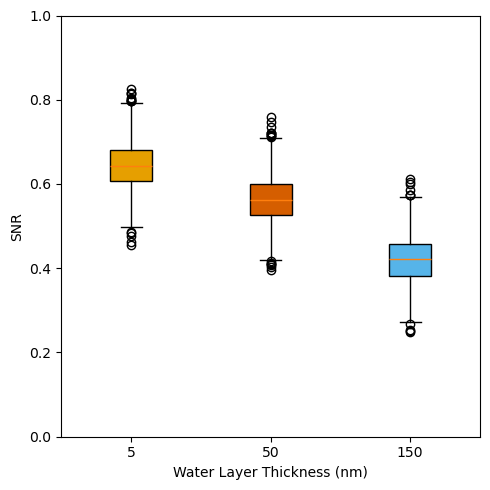

In [18]:
# Load in SNR arrays
path5 = os.path.join('../Data/water_layer_5nm/snr_values_5.npy')
path50 = os.path.join('../Data/water_layer_50nm/snr_values_50.npy')
path150 = os.path.join('../Data/water_layer_150nm/snr_values_150.npy')

snr5 = np.load(path5)
snr50 = np.load(path50)
snr150 = np.load(path150)

snr = snr5[0:275]

print(np.max(snr5), np.min(snr5))
print(np.max(snr50), np.min(snr50))
print(np.max(snr150), np.min(snr150))

snrs = [snr5, snr50, snr150]
thickness = [5, 50, 150]

plt.figure(figsize=(5,5))
box = plt.boxplot(snrs, patch_artist=True, positions=np.arange(len(snrs)), vert=True, labels = thickness)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(np.arange(len(thickness)), thickness)

plt.xlabel('Water Layer Thickness (nm)')
plt.ylabel('SNR')
plt.ylim(0, 1)

plt.tight_layout()

# fname = 'boxplots_snr.pdf'
# plt.savefig(fname, format ="pdf", bbox_inches='tight')

plt.show()


# Points, all frames

### Load in predicted masks

In [19]:
# Load in masks array
predictions5_path = '../Data/water_layer_5nm/5nm_points0-125_275frames.pkl'
predictions50_path = '../Data/water_layer_50nm/50nm_points0-125_275frames.pkl'
predictions150_path = '../Data/water_layer_150nm/150nm_points0-125_275frames.pkl'


with open(predictions5_path, 'rb') as f:
    predictions5_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions5 = []

for frame_idx in range(len(predictions5_dict)):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions5_dict[frame_idx][1][0]
    predictions5.append(frame_i_array)

predictions5 = np.array(predictions5)

# Load in masks array
with open(predictions50_path, 'rb') as f:
    predictions50_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions50 = []

for frame_idx in range(len(predictions50_dict)):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions50_dict[frame_idx][1][0]
    predictions50.append(frame_i_array)

predictions50 = np.array(predictions50)


# Load in masks array
with open(predictions150_path, 'rb') as f:
    predictions150_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions150 = []

for frame_idx in range(len(predictions150_dict)):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions150_dict[frame_idx][1][0]
    predictions150.append(frame_i_array)

predictions150 = np.array(predictions150)

predictions_points = [predictions5, predictions50, predictions150]

Video segments loaded successfully!
Video segments loaded successfully!
Video segments loaded successfully!


### Calculate Metrics

In [20]:
avg_jandf = []
jandf_scores = []
for i in range(len(thickness)):
    avg_f1, avg_jaccard, f1_scores, jaccard_scores  = calculate_metrics_across_frames(labels, predictions_points[i])
    jandfs, overall_jandf = calculate_jandf(f1_scores, jaccard_scores)
    jandf_scores.append(jandfs)
    avg_jandf.append(overall_jandf)
    print(f"Average Jaccard Index for water thickness {thickness[i]} nm: {avg_jaccard}")
    print(f"Average F1 Score for water thickness {thickness[i]} nm: {avg_f1}")
    print(f'J&F Score for water thickness {thickness[i]} nm: {overall_jandf}')

jandf_scores_points = jandf_scores
avg_jandf_points = avg_jandf

Average Jaccard Index for water thickness 5 nm: 78.07108794623788
Average F1 Score for water thickness 5 nm: 93.05056149760908
J&F Score for water thickness 5 nm: 85.56082472192347
Average Jaccard Index for water thickness 50 nm: 76.70890587688226
Average F1 Score for water thickness 50 nm: 91.04474055717972
J&F Score for water thickness 50 nm: 83.87682321703099
Average Jaccard Index for water thickness 150 nm: 64.43929538497505
Average F1 Score for water thickness 150 nm: 76.40946514279902
J&F Score for water thickness 150 nm: 70.42438026388703


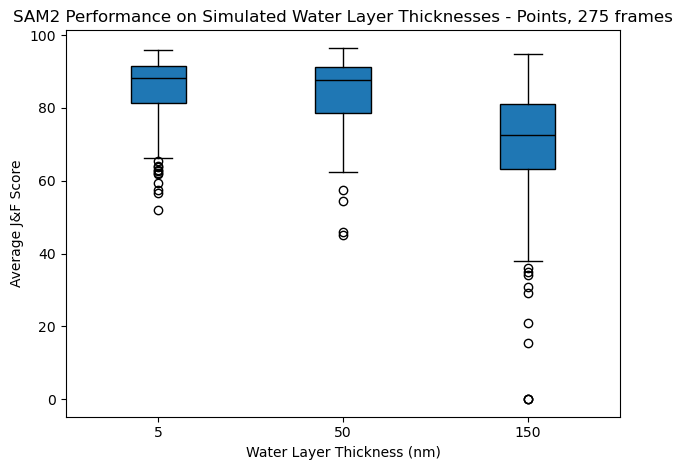

In [21]:
plt.boxplot(jandf_scores_points, labels = thickness, patch_artist=True, 
            medianprops={'color': 'black'}, 
            )
plt.xlabel('Water Layer Thickness (nm)')
plt.ylabel('Average J&F Score')
plt.title('SAM2 Performance on Simulated Water Layer Thicknesses - Points, 275 frames')
plt.tight_layout()

# Boxes at 0 and 125 frames, first 275 frames

### Load in predicted masks

In [22]:
# Load in masks array
predictions5_path = '../Data/water_layer_5nm/5nm_boxes0-125_275frames.pkl'
predictions50_path = '../Data/water_layer_50nm/50nm_boxes0-125_275frames.pkl'
predictions150_path = '../Data/water_layer_150nm/150nm_boxes0-125_275frames.pkl'


with open(predictions5_path, 'rb') as f:
    predictions5_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions5 = []
for frame_idx in range(275):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions5_dict[frame_idx][0][0]
    predictions5.append(frame_i_array)

predictions5 = np.array(predictions5)


# Load in masks array
with open(predictions50_path, 'rb') as f:
    predictions50_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions50 = []

for frame_idx in range(275):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions50_dict[frame_idx][0][0]
    predictions50.append(frame_i_array)

predictions50 = np.array(predictions50)

# Load in masks array
with open(predictions150_path, 'rb') as f:
    predictions150_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions150 = []

for frame_idx in range(275):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions150_dict[frame_idx][0][0]
    predictions150.append(frame_i_array)

predictions150 = np.array(predictions150)

predictions_box = [predictions5, predictions50, predictions150]

Video segments loaded successfully!
Video segments loaded successfully!
Video segments loaded successfully!


### Calculate Metrics

In [23]:
thickness = [5, 50, 150]
avg_jandf_box = []
jandf_scores_box = []
for i in range(len(thickness)):
    avg_f1_box, avg_jaccard_box, f1_scores_box, jaccard_scores_box  = calculate_metrics_across_frames(labels, predictions_box[i])
    jandfs_box, overall_jandf_box = calculate_jandf(f1_scores_box, jaccard_scores_box)
    jandf_scores_box.append(jandfs_box)
    avg_jandf_box.append(overall_jandf_box)
    print(f"Average Jaccard Index for water thickness {thickness[i]} nm: {avg_jaccard_box}")
    print(f"Average F1 Score for water thickness {thickness[i]} nm: {avg_f1_box}")
    print(f'J&F Score for water thickness {thickness[i]} nm: {overall_jandf_box}')

Average Jaccard Index for water thickness 5 nm: 80.57633594360688
Average F1 Score for water thickness 5 nm: 94.71530196247456
J&F Score for water thickness 5 nm: 87.64581895304072
Average Jaccard Index for water thickness 50 nm: 76.2084292507022
Average F1 Score for water thickness 50 nm: 89.11664544883608
J&F Score for water thickness 50 nm: 82.66253734976912
Average Jaccard Index for water thickness 150 nm: 63.640823576785436
Average F1 Score for water thickness 150 nm: 70.8962288891614
J&F Score for water thickness 150 nm: 67.26852623297341


(0.0, 100.0)

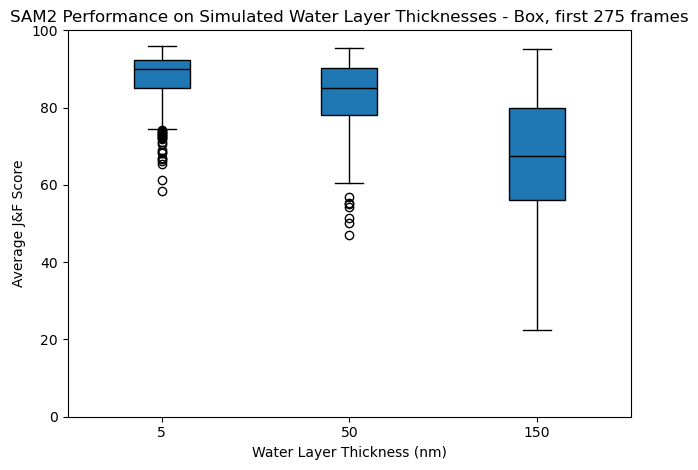

In [24]:
plt.boxplot(jandf_scores_box, labels = thickness, patch_artist=True, 
            medianprops={'color': 'black'}, 
            )
plt.xlabel('Water Layer Thickness (nm)')
plt.ylabel('Average J&F Score')
plt.title('SAM2 Performance on Simulated Water Layer Thicknesses - Box, first 275 frames')
plt.tight_layout()
plt.ylim(0, 100)

## Box + Point

In [25]:
# Load in masks array
predictions5_path = '../Data/water_layer_5nm/5nm_box_point_0-125_275frames_video_segments_final.pkl'
predictions50_path = '../Data/water_layer_50nm/50nm_box_point_0-125_275frames_video_segments_final.pkl'
predictions150_path = '../Data/water_layer_150nm/150nm_box_point_0-125_275frames_video_segments_final.pkl'


with open(predictions5_path, 'rb') as f:
    predictions5_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions5 = []
for frame_idx in range(275):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions5_dict[frame_idx][1][0]
    predictions5.append(frame_i_array)

predictions5 = np.array(predictions5)


# Load in masks array
with open(predictions50_path, 'rb') as f:
    predictions50_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions50 = []

for frame_idx in range(275):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions50_dict[frame_idx][1][0]
    predictions50.append(frame_i_array)

predictions50 = np.array(predictions50)


# Load in masks array
with open(predictions150_path, 'rb') as f:
    predictions150_dict = pickle.load(f)
print("Video segments loaded successfully!")

# turn dictionary of video segments into array
predictions150 = []

for frame_idx in range(275):
    # Access the 0th element of the list for each frame (masks5_dict[frame_idx][1][0])
    frame_i_array = predictions150_dict[frame_idx][1][0]
    predictions150.append(frame_i_array)

predictions150 = np.array(predictions150)

predictions_boxpoint = [predictions5, predictions50, predictions150]


Video segments loaded successfully!
Video segments loaded successfully!
Video segments loaded successfully!


In [26]:
thickness = [5, 50, 150]
avg_jandf_boxpoint = []
jandf_scores_boxpoint = []
for i in range(len(thickness)):
    avg_f1, avg_jaccard, f1_scores, jaccard_scores  = calculate_metrics_across_frames(labels, predictions_boxpoint[i])
    jandfs, overall_jandf = calculate_jandf(f1_scores, jaccard_scores)
    jandf_scores_boxpoint.append(jandfs)
    avg_jandf_boxpoint.append(overall_jandf)
    print(f"Average Jaccard Index for water thickness {thickness[i]} nm: {avg_jaccard}")
    print(f"Average F1 Score for water thickness {thickness[i]} nm: {avg_f1}")
    print(f'J&F Score for water thickness {thickness[i]} nm: {overall_jandf}')

Average Jaccard Index for water thickness 5 nm: 79.51335739426482
Average F1 Score for water thickness 5 nm: 94.3535572473096
J&F Score for water thickness 5 nm: 86.93345732078721
Average Jaccard Index for water thickness 50 nm: 77.19811877532739
Average F1 Score for water thickness 50 nm: 91.19469707806628
J&F Score for water thickness 50 nm: 84.19640792669685
Average Jaccard Index for water thickness 150 nm: 65.18787065866528
Average F1 Score for water thickness 150 nm: 74.68591275747534
J&F Score for water thickness 150 nm: 69.9368917080703


(0.0, 100.0)

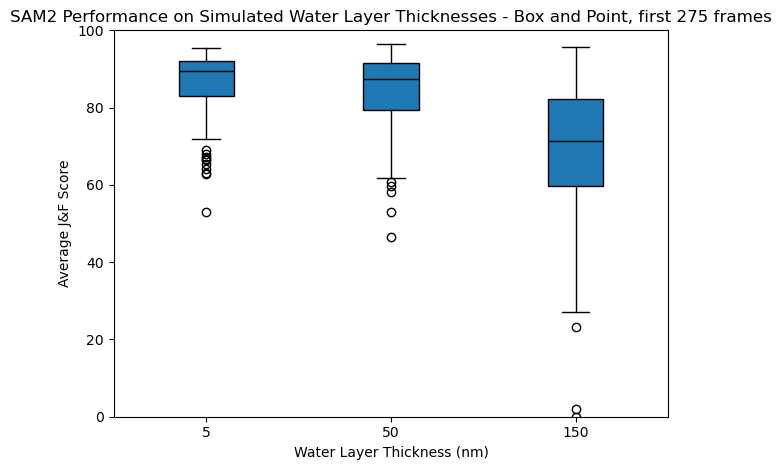

In [27]:
plt.boxplot(jandf_scores_boxpoint, labels = thickness, patch_artist=True, 
            medianprops={'color': 'black'}, 
            )
plt.xlabel('Water Layer Thickness (nm)')
plt.ylabel('Average J&F Score')
plt.title('SAM2 Performance on Simulated Water Layer Thicknesses - Box and Point, first 275 frames')
plt.tight_layout()
plt.ylim(0, 100)

## U-Net Predictions

In [28]:
predictions5_path = '../Data/water_layer_5nm/5nm_unet_predictions'
predictions50_path = '../Data/water_layer_50nm/50nm_unet_predictions'
predictions150_path = '../Data/water_layer_150nm/150nm_unet_predictions'
paths = [predictions5_path, predictions50_path, predictions150_path]


predictions5 = []
predictions50 = []
predictions150 = []

predictions_unet = [predictions5, predictions50, predictions150]

threshold = 0.5 # for binarizing

for i, path in enumerate(paths):
    prediction_arr = []
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if file_path.lower().endswith(('tif')):
            with Image.open(file_path) as img:

                # convert image to array
                image_array = np.array(img)

                # binarize image
                image_array = np.where(image_array >= threshold, True, False)

                prediction_arr.append(image_array)
    
    predictions_unet[i] = np.array(prediction_arr)


labels = labels[:275]

In [29]:
thickness = [5, 50, 150]
avg_jandf_unet = []
jandf_scores_unet = []
for i in range(len(thickness)):
    avg_f1, avg_jaccard, f1_scores, jaccard_scores  = calculate_metrics_across_frames(labels, predictions_unet[i])
    jandfs, overall_jandf = calculate_jandf(f1_scores, jaccard_scores)
    jandf_scores_unet.append(jandfs)
    avg_jandf_unet.append(overall_jandf)
    print(f"Average Jaccard Index for water thickness {thickness[i]} nm: {avg_jaccard}")
    print(f"Average F1 Score for water thickness {thickness[i]} nm: {avg_f1}")
    print(f'J&F Score for water thickness {thickness[i]} nm: {overall_jandf}')

Average Jaccard Index for water thickness 5 nm: 2.447987788512766
Average F1 Score for water thickness 5 nm: 2.114366491185554
J&F Score for water thickness 5 nm: 2.2811771398491603
Average Jaccard Index for water thickness 50 nm: 2.35147758661925
Average F1 Score for water thickness 50 nm: 2.2487995710816797
J&F Score for water thickness 50 nm: 2.300138578850465
Average Jaccard Index for water thickness 150 nm: 2.241651342108418
Average F1 Score for water thickness 150 nm: 2.1773793875858605
J&F Score for water thickness 150 nm: 2.2095153648471397


(0.0, 100.0)

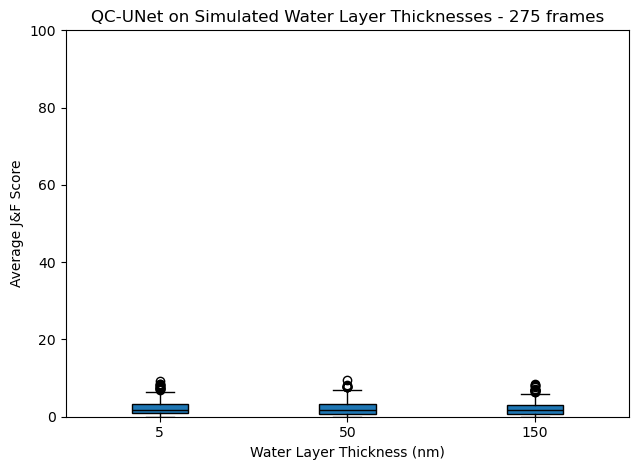

In [30]:
plt.boxplot(jandf_scores_unet, labels = thickness, patch_artist=True, 
            medianprops={'color': 'black'}, 
            )
plt.xlabel('Water Layer Thickness (nm)')
plt.ylabel('Average J&F Score')
plt.title('QC-UNet on Simulated Water Layer Thicknesses - 275 frames')
plt.tight_layout()
plt.ylim(0, 100)

# Figures

In [31]:
methods = {"SAM2, Points": jandf_scores_points, "SAM2, Box": jandf_scores_box, "SAM2, Points and Box": jandf_scores_boxpoint, "U-Net": jandf_scores_unet }
colors = [
    "#E69F00",  # Orange
    "#D55E00",   # Red-orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Green
    "#0072B2", # Blue
    "#CC79A7", # Pink
    "#F0E442", # Yellow
    "#B3D100",  # Yellow-green
    "#9E1B32"  # Dark red
]

SAM2, Points medians: [88.12852516829594, 87.62209557326813, 72.58305933809405]
SAM2, Box medians: [90.01182033096927, 85.04497111560542, 67.47128116053261]
SAM2, Points and Box medians: [89.46334973773709, 87.49716819650021, 71.31282078940035]
U-Net medians: [1.7227953194525574, 1.734801355813877, 1.850935605911627]


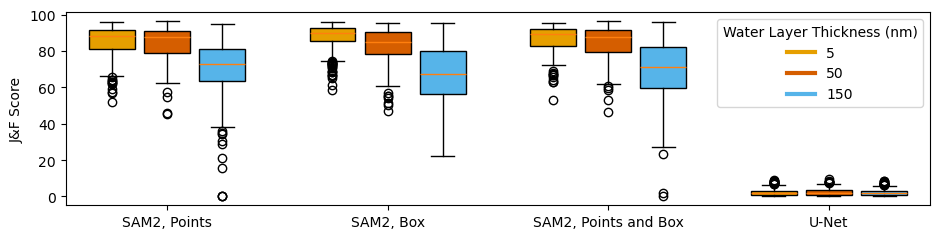

In [32]:
# all 4 methods
methods = {"SAM2, Points": jandf_scores_points, "SAM2, Box": jandf_scores_box, "SAM2, Points and Box": jandf_scores_boxpoint, "U-Net": jandf_scores_unet }

data_by_method = [
    [methods[method][i] for i in range(len(thickness))]  # Collect data for all thicknesses for each method
    for method in methods
]

# Plot setup
fig, ax = plt.subplots(figsize=(9.5,2.5))
positions = [] 
width = .5  # Width of each group
group_spacing = .6  # Space between methods
box_spacing = 0.6  # Space between thicknesses within a method

base = 0
for group in data_by_method:
    for i in range(len(group)):
        positions.append(base + i * box_spacing)
    base += len(group) * box_spacing + group_spacing

# Flatten the data for `boxplot` input
flattened_data = [item for group in data_by_method for item in group]

bplot = ax.boxplot(flattened_data, positions=positions, patch_artist=True, widths=0.5)

# get medians
medians_by_method = {}
median_idx = 0  
for method, group in zip(methods.keys(), data_by_method):
    method_medians = []  # List to hold median values for the current method
    for i in range(len(group)):
        median_value = bplot['medians'][median_idx].get_ydata()[0] 
        method_medians.append(median_value)
        median_idx += 1 
    medians_by_method[method] = method_medians
for method, medians in medians_by_method.items():
    print(f"{method} medians: {medians}")

for patch, thickness_index in zip(bplot['boxes'], [i % len(thickness) for i in range(len(flattened_data))]):
    patch.set_facecolor(colors[thickness_index])

x_ticks = np.arange(len(methods)) * (len(thickness) * box_spacing + group_spacing) + (len(thickness) - 1) * box_spacing / 2
ax.set_xticks(x_ticks)
ax.set_xticklabels(methods.keys())
ax.set_ylabel("J&F Score")
# ax.set_title("Performance on 275 Frames")

# Add a legend for the thicknesses
legend_patches = [plt.Line2D([0], [0], color=color, lw=3) for color in colors]
ax.legend(legend_patches, thickness, title="Water Layer Thickness (nm)", loc="upper right")

plt.tight_layout()


# fname = 'boxplots_4 methods.pdf'
# plt.savefig(fname, format ="pdf", bbox_inches='tight')

plt.show()

Print results to excel file

In [33]:
import pandas as pd
len(jandf_scores_points)
points_df = pd.DataFrame(jandf_scores_points).transpose()
points_df.columns=[f'{t} nm' for t in thickness]

box_df = pd.DataFrame(jandf_scores_box).transpose()
box_df.columns=[f'{t} nm' for t in thickness]

boxpoint_df = pd.DataFrame(jandf_scores_boxpoint).transpose()
boxpoint_df.columns=[f'{t} nm' for t in thickness]

unet_df = pd.DataFrame(jandf_scores_unet).transpose()
unet_df.columns=[f'{t} nm' for t in thickness]

In [34]:
with pd.ExcelWriter('J&F Scores.xlsx') as writer:
    points_df.to_excel(writer, sheet_name = 'Points')
    box_df.to_excel(writer, sheet_name = 'Box')
    boxpoint_df.to_excel(writer, sheet_name = 'Box and Point')
    unet_df.to_excel(writer, sheet_name = 'U-Net')